This tutorial breaks down the processing pipeline from raw data up to hits identification, in the `qualiphide_thz_offline` context and algorithms (plugins) of `straxion v0.2.0`.

Lanqing Yuan, Sep 22, 2025.

# Pre-knowledge

In [1]:
import straxion
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Set options to display all rows and columns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)  # To prevent truncation of long cell contents


# Apply the plotting style. You can also comment it out to use the default style.
plt.style.use("../.customized_mplstyle")
straxion.register_xenon_colors()

In this tutorial, we assume that you already have access to the resonator fine scan as well as time stream data prepared in a format as follow. The scope of these data might only make sesne to QUALIPHIDE collaboration for now, and they are not made public.

In [2]:
!ls /Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/

QUALIPHIDE_Analysis.ipynb
fres_2dB-1756824887.npy
iq_fine_f_2dB_below_pcrit-1756824887.npy
iq_fine_z_2dB_below_pcrit-1756824887.npy
iq_wide_f_2dB_below_pcrit-1756824887.npy
iq_wide_z_2dB_below_pcrit-1756824887.npy
ts_38kHz-1756824965.npy
ts_38kHz-1756825045.npy
ts_38kHz-1756825122.npy
ts_38kHz-1756825195.npy
ts_38kHz-1756825265.npy


To load data, we will need to define a `strax.Context` object, in which all the detector-specific processing-related information is defined.

In [3]:
st = straxion.qualiphide_thz_offline()  # Used for offline analysis

run = 1756824965
DAQ_INPUT_DIR = f"/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/ts_38kHz-{run}.npy"
IQ_FINESCAN_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
IQ_WIDESCAN_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
IQ_FINESCAN_FILENAME = "iq_fine_z_2dB_below_pcrit-1756824887.npy"
IQ_WIDESCAN_FILENAME = "iq_wide_z_2dB_below_pcrit-1756824887.npy"
RESONANT_FREQUENCY_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
RESONANT_FREQUENCY_FILENAME = "fres_2dB-1756824887.npy"
run = str(run)

configs = dict(
    daq_input_dir=DAQ_INPUT_DIR,
    iq_finescan_dir=IQ_FINESCAN_DIR,
    iq_finescan_filename=IQ_FINESCAN_FILENAME,
    iq_widescan_dir=IQ_WIDESCAN_DIR,
    iq_widescan_filename=IQ_WIDESCAN_FILENAME,
    resonant_frequency_dir=RESONANT_FREQUENCY_DIR,
    resonant_frequency_filename=RESONANT_FREQUENCY_FILENAME,
)
st.set_config(configs)

For example, all the technical configuration regarding computation can be found already stored in the context. It is beyond regular users to understand what they are exactly though, for which avid users want to consult the strax documentation.

In [4]:
st.show_config()

,option,default,current,applies_to,help
0,fuzzy_for,(),(),Context,"Tuple or string of plugin names for which no checks for version, providing plugin, and config will be performed when looking for data."
1,fuzzy_for_options,(),(),Context,Tuple of config options for which no checks will be performed when looking for data.
2,allow_incomplete,False,False,Context,"Allow loading of incompletely written data, if the storage systems support it"
3,allow_rechunk,True,True,Context,Allow rechunking of data during writing.
4,allow_multiprocess,False,False,Context,"Allow multiprocessing.If False, will use multithreading only."
5,allow_shm,False,False,Context,Allow use of /dev/shm for interprocess communication.
6,allow_lazy,True,True,Context,"Allow ""lazy"" processing. Saves memory, but incompatible with multiprocessing and perhaps slightly slower."
7,forbid_creation_of,(),(),Context,"If any of the following datatypes is requested to be created, throw an error instead. Useful to limit descending too far into the dependency graph."
8,store_run_fields,(),"(name, start, end, livetime, mode)",Context,Tuple of run document fields to store during scan_run.
9,check_available,(),(),Context,Tuple of data types to scan availability for during scan_run.


The processing algorithms are broken down into significant steps called plugins, inserted into the context. Below are the implemented plugins so far in straxion `v0.1.1`.

In [5]:
st._plugin_class_registry

{'raw_records': straxion.plugins.raw_records.QUALIPHIDETHzReader,
 'records': straxion.plugins.records.DxRecords,
 'hits': straxion.plugins.hits.DxHits,
 'hit_classification': straxion.plugins.hit_classification.SpikeCoincidence,
 'noises': straxion.plugins.noise_bank.NoiseBank,
 'truth': straxion.plugins.truth.Truth,
 'match': straxion.plugins.match.Match}

In the following of this tutorial, we will dive into these plugins in order of dependency.

# Plugins

## `raw_records`

In [6]:
?straxion.QUALIPHIDETHzReader

Init signature: straxion.QUALIPHIDETHzReader()
Docstring:     
DAQ reader for the QUALIPHIDE THz detector.

Assumed the IQ timestream is already in an npy file, where axis 0 is the channel, axis 1 is the
time of equal spacing. The time stream is complex.

Truncate the time stream to the record length.
File:           ~/Documents/GitHub/straxion/straxion/plugins/raw_records.py
Type:           type
Subclasses:     

The following command loads the raw_records data into memory. Note that, to save disk space, `raw_records` is not saved by default. You have to specify it to save it.

In [7]:
raw_records = st.get_array(run, "raw_records")

# If you want to save it, you can do so by:
# raw_records = st.get_array(run, "raw_records", save=("raw_records"))

Could not estimate run start and end time from run metadata: assuming it is 0 and inf


Source finished!


All the data we computed are saved in the output folder defined by the context:

In [8]:
st.storage

[strax.storage.files.DataDirectory (path: ./strax_data)]

You can see that the data are named by `<run_id>-<data_type>-<lineage_hash>`, where the hash is uniquely determined by the tracked lineage of configuration. The motivation for this design is that we will not run into problems loading data computed by different configuration (For example, you might have changed a threshold value somewhere and forgot. This will not hurt you in straxion).


As an example, here are the tracked lineage for raw_records. Higher level plugins might have much more complicated lineage.

In [9]:
st.lineage(run, "raw_records")

{'raw_records': ('QUALIPHIDETHzReader',
  '0.0.0',
  {'fs': 38000, 'sub_detector': 'kids'})}

It gives the hash.

In [10]:
st.key_for(run, "raw_records")

1756824965-raw_records-biptyywnjf

Now let's see what do we have in raw_records:

In [11]:
st.data_info("raw_records")

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,endtime,int64,Exclusive end time since unix epoch [ns]
2,length,int64,Length of the interval in samples
3,dt,int64,"Width of one sample [ns], which is not exact due to the int conversion"
4,channel,int16,Channel number defined by channel_map
5,data_i,"('<f4', (1900000,))",Waveform data of I in raw ADC counts
6,data_q,"('<f4', (1900000,))",Waveform data of Q in raw ADC counts


Each element of the loaded array correspond to one channel. We will just inspect one for illustration.

In [12]:
np.shape(raw_records)

(41,)

In [13]:
raw_records = raw_records[raw_records["channel"] == 0]

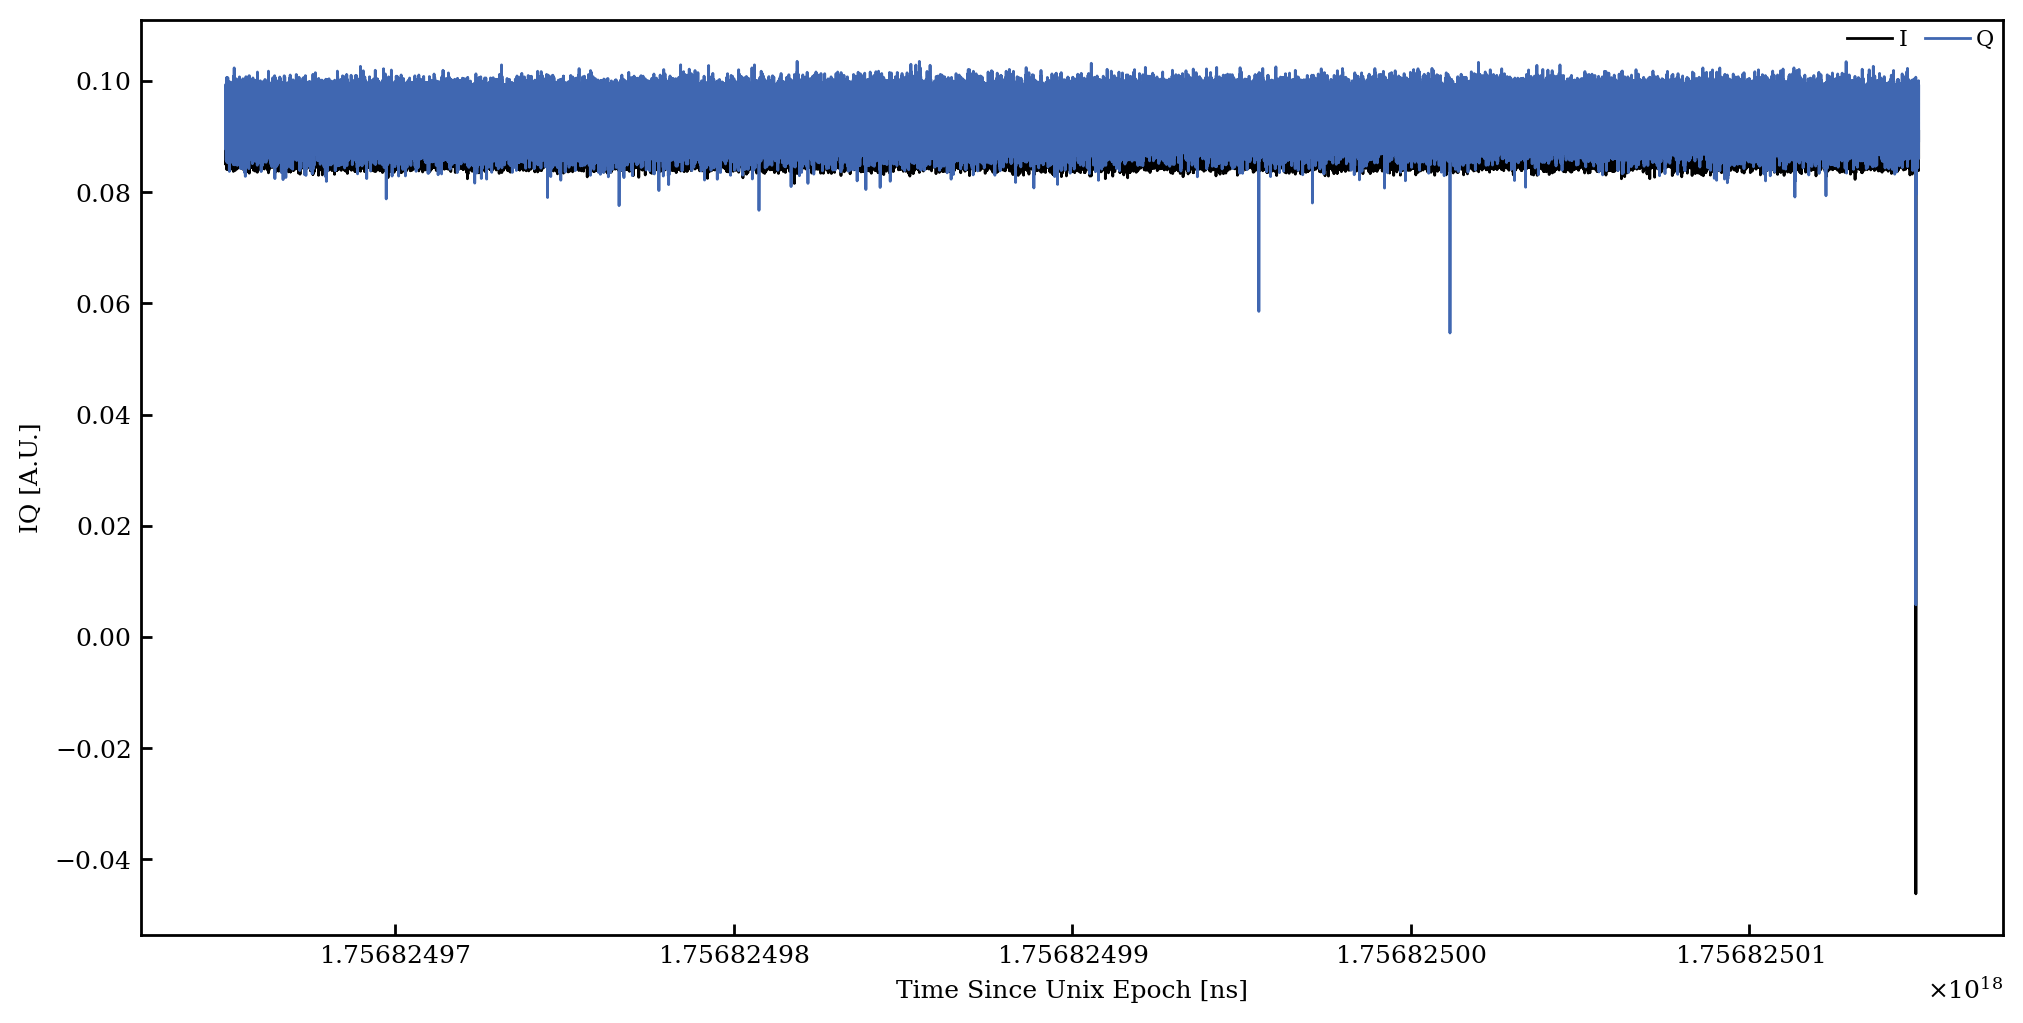

In [14]:
plt.figure(figsize=(10, 5))

plt.plot(
    raw_records[0]["time"] + np.arange(raw_records[0]["length"]) * raw_records[0]["dt"],
    raw_records[0]["data_i"],
    label="I",
)
plt.plot(
    raw_records[0]["time"] + np.arange(raw_records[0]["length"]) * raw_records[0]["dt"],
    raw_records[0]["data_q"],
    label="Q",
)
plt.xlabel("Time Since Unix Epoch [ns]")
plt.ylabel("IQ [A.U.]")
plt.legend(ncol=2, loc="upper right")
plt.show()

## `hits`, `hit_classification` and `noises`

In [15]:
st.show_config("hits")

,option,default,current,applies_to,help
0,hit_threshold_dx,None,<OMITTED>,"(hits,)","Threshold for hit finding in units of dx=df/f0. If None, the hit threshold will be calculated based on the signal statistics."
1,hit_thresholds_sigma,"[3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0]",<OMITTED>,"(hits,)","Threshold for hit finding in units of sigma of standard deviation of the noise. If None, the hit threshold will be calculated based on the signal statistics."
2,hit_min_width,0.00025,<OMITTED>,"(hits,)",Minimum width for hit finding in units of seconds.
3,fs,38000,<OMITTED>,"(hits,)",Sampling frequency (assumed the same for all channels) in unit of Hz
4,iq_finescan_dir,<OMITTED>,/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/,"(records,)",Direcotry to fine frequency scan (IQ loop) of resonatorm.
5,iq_widescan_dir,<OMITTED>,/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/,"(records,)",Direcotry to wide frequency scan (IQ loop) of resonatorm.
6,resonant_frequency_dir,<OMITTED>,/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/,"(records,)",Direcotry to resonant frequency npy file.
7,iq_finescan_filename,<OMITTED>,iq_fine_z_2dB_below_pcrit-1756824887.npy,"(records,)","(Filename of the fine frequency scan (IQ loop) of resonator npy file, just the filename. Assumed the filename starts with iq_fine_<f/z>_*-<TIME>,)"
8,iq_widescan_filename,<OMITTED>,iq_wide_z_2dB_below_pcrit-1756824887.npy,"(records,)","(Filename of the fine frequency scan (IQ loop) of resonator npy file, just the filename. Assumed the filename starts with iq_wide_<f/z>_*-<TIME>,)"
9,resonant_frequency_filename,<OMITTED>,fres_2dB-1756824887.npy,"(records,)","(Filename of the resonant frequency npy file, just the filename, not the path. Assumed the filename starts with fres_*-<TIME>,)"


In [16]:
records = st.get_array(run, "records", save=("records"))
hits = st.get_array(run, ("hits", "hit_classification"))
noises = st.get_array(run, ("noises"))

/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  self.interpolated_freqs[ch] = self.f_interpolation_models[ch](0)
Could not estimate run start and end time from run metadata: assuming it is 0 and inf
/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:542: ComplexWarning: Casting complex values to real discards the imaginary part
  r["data_dtheta"] = dtheta
/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:545: ComplexWarning: Casting complex values to real discards the imaginary part
  r["data_dx"] = (


Source finished!


/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/strax/plugins/plugin.py:212: UserWarning: 
            Looks like you are mixing config paradigms,
            this is not recommended.
            
  warn(message, UserWarning)
/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/strax/plugins/plugin.py:212: UserWarning: 
            Looks like you are mixing config paradigms,
            this is not recommended.
            
  warn(message, UserWarning)
/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/strax/plugins/plugin.py:212: UserWarning: 
            Looks like you are mixing config paradigms,
            this is not recommended.
            
  warn(message, UserWarning)
/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/strax/plugins/plugin.py:212: UserWarning: 
            Looks like you are mixing config paradigms,
            this is not recommended.
            
  warn(message, UserWarning)
Loading noises: |██████████| 100.00 % [00:01<00:00], #1 

In [17]:
records0 = records[records["channel"] == 0][0]
hits0 = hits[hits["channel"] == 0]
noises0 = noises[noises["channel"] == 0]

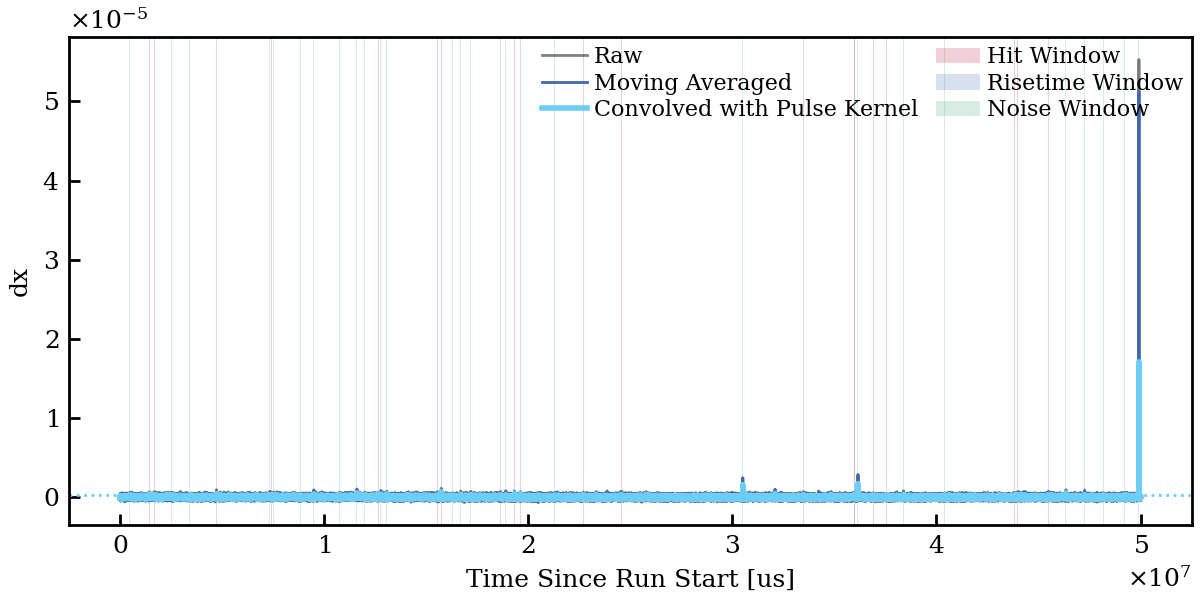

In [22]:
%matplotlib widget

times_start = records0["time"]
times_us = (records0["time"] + np.arange(records0["length"]) * records0["dt"] - times_start) / 1e3

plt.figure(figsize=(6, 3))
plt.plot(
    times_us,
    records0["data_dx"],
    label="Raw",
    # color="black",
    alpha=0.5,
    lw=1,
)
plt.plot(
    times_us,
    records0["data_dx_moving_average"],
    # color="tab:blue",
    lw=1,
    label="Moving Averaged",
)
plt.plot(
    times_us,
    records0["data_dx_convolved"],
    # color="tab:orange",
    lw=2,
    label="Convolved with Pulse Kernel",
)

for k, hit in enumerate(hits0):
    hit_start_us = (hit["time"] - times_start) / 1e3
    hit_end_us = (hit["endtime"] - times_start) / 1e3

    if k == 0:
        plt.axvspan(
            hit_start_us, hit_end_us, alpha=0.2, color="xenon_red", lw=0, label="Hit Window"
        )
        plt.axvspan(
            times_us[hit["amplitude_moving_average_max_record_i"] - 5],
            times_us[hit["amplitude_moving_average_max_record_i"]],
            color="xenon_blue",
            alpha=0.2,
            lw=0,
            label="Risetime Window",
        )
    else:
        plt.axvspan(hit_start_us, hit_end_us, alpha=0.2, color="xenon_red", lw=0)
        plt.axvspan(
            times_us[hit["amplitude_moving_average_max_record_i"] - 5],
            times_us[hit["amplitude_moving_average_max_record_i"]],
            color="xenon_blue",
            alpha=0.2,
            lw=0,
        )
    # plt.axvline(hit["amplitude_max_record_i"] * records0["dt"] / 1e3, color="xenon_red")

for k, noise in enumerate(noises0):
    noise_start_us = (noise["time"] - times_start) / 1e3
    noise_end_us = (noise["endtime"] - times_start) / 1e3
    if k == 0:
        plt.axvspan(
            noise_start_us, noise_end_us, alpha=0.2, color="xenon_green", lw=0, label="Noise Window"
        )
    else:
        plt.axvspan(noise_start_us, noise_end_us, alpha=0.2, color="xenon_green", lw=0)

plt.axhline(hit["hit_threshold"], color="xenon_light_blue", ls=":")
plt.legend(ncol=2, loc="best")
plt.xlabel("Time Since Run Start [us]")
plt.ylabel("dx")
plt.show()

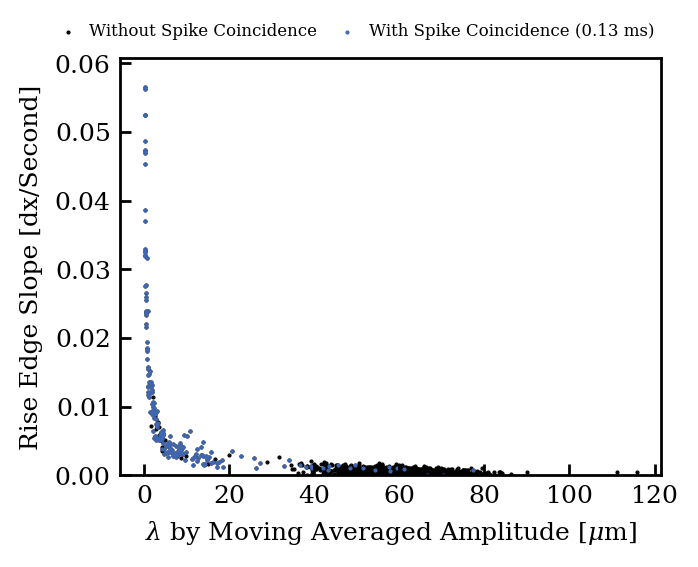

In [24]:
%matplotlib inline


def dx_to_um(ht):
    return 3e14 / ((ht) / (1.5e-6) * 12e12)


def dx_to_THz(ht):
    return (ht) / (1.5e-6) * 12


plt.scatter(
    dx_to_um(hits["amplitude_moving_average"]),
    hits["rise_edge_slope"],
    label="Without Spike Coincidence",
    s=1,
)
plt.scatter(
    dx_to_um(hits[hits["is_coincident_with_spikes"]]["amplitude_moving_average"]),
    hits[hits["is_coincident_with_spikes"]]["rise_edge_slope"],
    label="With Spike Coincidence (0.13 ms)",
    s=1,
)
plt.xlabel(r"$\lambda$ by Moving Averaged Amplitude [$\mu$m]")
plt.ylabel(r"Rise Edge Slope [dx/Second]")
plt.legend(loc="best", fontsize=6, bbox_to_anchor=(1.0, 1.1), ncol=2)
plt.ylim(
    0,
)
plt.show()

In [25]:
photon_candidates = hits[hits["is_photon_candidate"]]

print("Total exposure: 50 seconds")
print("Total number of photon candidates: ", len(photon_candidates))
print("Total number of all hits: ", len(hits))
print(
    f"A spike tight coincidence of 0.131 ms is applied to the hits, which kills about {(len(hits)-len(photon_candidates))/len(hits)*100:.2f}% of the hits."
)

Total exposure: 50 seconds
Total number of photon candidates:  882
Total number of all hits:  1124
A spike tight coincidence of 0.131 ms is applied to the hits, which kills about 21.53% of the hits.


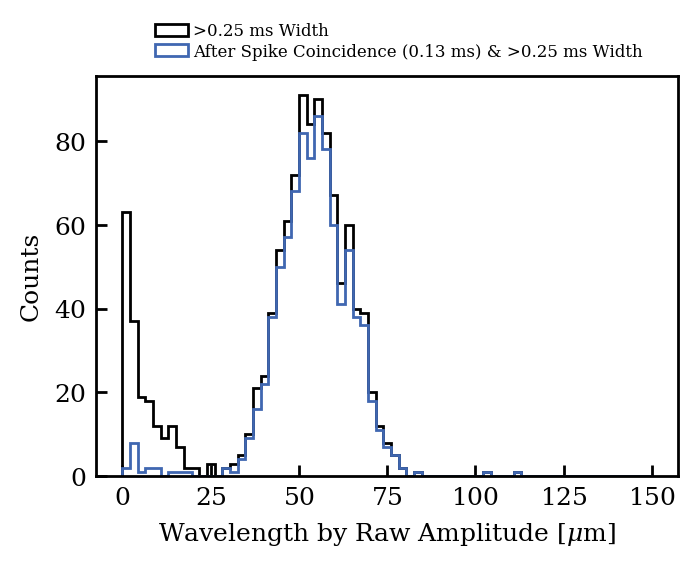

In [26]:
%matplotlib inline
plt.hist(
    dx_to_um(hits["amplitude"]),
    bins=np.linspace(0, 150, 70),
    histtype="step",
    label=">0.25 ms Width",
)
plt.hist(
    dx_to_um(photon_candidates["amplitude"]),
    bins=np.linspace(0, 150, 70),
    histtype="step",
    label="After Spike Coincidence (0.13 ms) & >0.25 ms Width",
)
plt.xlabel(r"Wavelength by Raw Amplitude [$\mu$m]")
plt.legend(loc="best", fontsize=6, bbox_to_anchor=(0.95, 1.15))
plt.ylabel("Counts")
plt.show()

# Simulation

In simulation, we can specify dark photon of certain energy showing up at constant time interval. Their `dx` waveforms are scaled from the template extracted from the PRX paper. They are salted into the `records` by directing adding `data_dx`.

Below, we specify salting rate to be 100 Hz, and the dark photon mass to be 70 meV. We put these configurations into a context called `st_salt`, where we will do the salting.

In [27]:
st_salt = straxion.qualiphide_thz_offline()

run = 1756824965
DAQ_INPUT_DIR = f"/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/ts_38kHz-{run}.npy"
IQ_FINESCAN_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
IQ_WIDESCAN_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
IQ_FINESCAN_FILENAME = "iq_fine_z_2dB_below_pcrit-1756824887.npy"
IQ_WIDESCAN_FILENAME = "iq_wide_z_2dB_below_pcrit-1756824887.npy"
RESONANT_FREQUENCY_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
RESONANT_FREQUENCY_FILENAME = "fres_2dB-1756824887.npy"
run = DAQ_INPUT_DIR.split("/")[-1].split(".npy")[0].split("-")[1]


configs = dict(
    daq_input_dir=DAQ_INPUT_DIR,
    iq_finescan_dir=IQ_FINESCAN_DIR,
    iq_finescan_filename=IQ_FINESCAN_FILENAME,
    iq_widescan_dir=IQ_WIDESCAN_DIR,
    iq_widescan_filename=IQ_WIDESCAN_FILENAME,
    resonant_frequency_dir=RESONANT_FREQUENCY_DIR,
    resonant_frequency_filename=RESONANT_FREQUENCY_FILENAME,
    salt_rate=100,  # Hz
    energy_meV=70,  # meV
)
st_salt.set_config(configs)

In [28]:
records_salt = st_salt.get_array(run, "records")

/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  self.interpolated_freqs[ch] = self.f_interpolation_models[ch](0)
Could not estimate run start and end time from run metadata: assuming it is 0 and inf
/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:542: ComplexWarning: Casting complex values to real discards the imaginary part
  r["data_dtheta"] = dtheta
/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:545: ComplexWarning: Casting complex values to real discards the imaginary part
  r["data_dx"] = (


Source finished!


To get the real data without salting, we just define another context without specifying `salt_rate` (so it's default to 0).

In [29]:
st_data = straxion.qualiphide_thz_offline()

run = 1756824965
DAQ_INPUT_DIR = f"/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/ts_38kHz-{run}.npy"
IQ_FINESCAN_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
IQ_WIDESCAN_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
IQ_FINESCAN_FILENAME = "iq_fine_z_2dB_below_pcrit-1756824887.npy"
IQ_WIDESCAN_FILENAME = "iq_wide_z_2dB_below_pcrit-1756824887.npy"
RESONANT_FREQUENCY_DIR = "/Users/lanqingyuan/Desktop/QUALIPHIDE_Science_Data/"
RESONANT_FREQUENCY_FILENAME = "fres_2dB-1756824887.npy"
run = DAQ_INPUT_DIR.split("/")[-1].split(".npy")[0].split("-")[1]


configs = dict(
    daq_input_dir=DAQ_INPUT_DIR,
    iq_finescan_dir=IQ_FINESCAN_DIR,
    iq_finescan_filename=IQ_FINESCAN_FILENAME,
    iq_widescan_dir=IQ_WIDESCAN_DIR,
    iq_widescan_filename=IQ_WIDESCAN_FILENAME,
    resonant_frequency_dir=RESONANT_FREQUENCY_DIR,
    resonant_frequency_filename=RESONANT_FREQUENCY_FILENAME,
)
st_data.set_config(configs)

In [30]:
records_data = st_data.get_array(run, "records")

Loading records: |██████████| 100.00 % [00:01<00:00], #1 (1.73 s). 719.1 MB/s


Let's compare the difference between the salted and the real data.

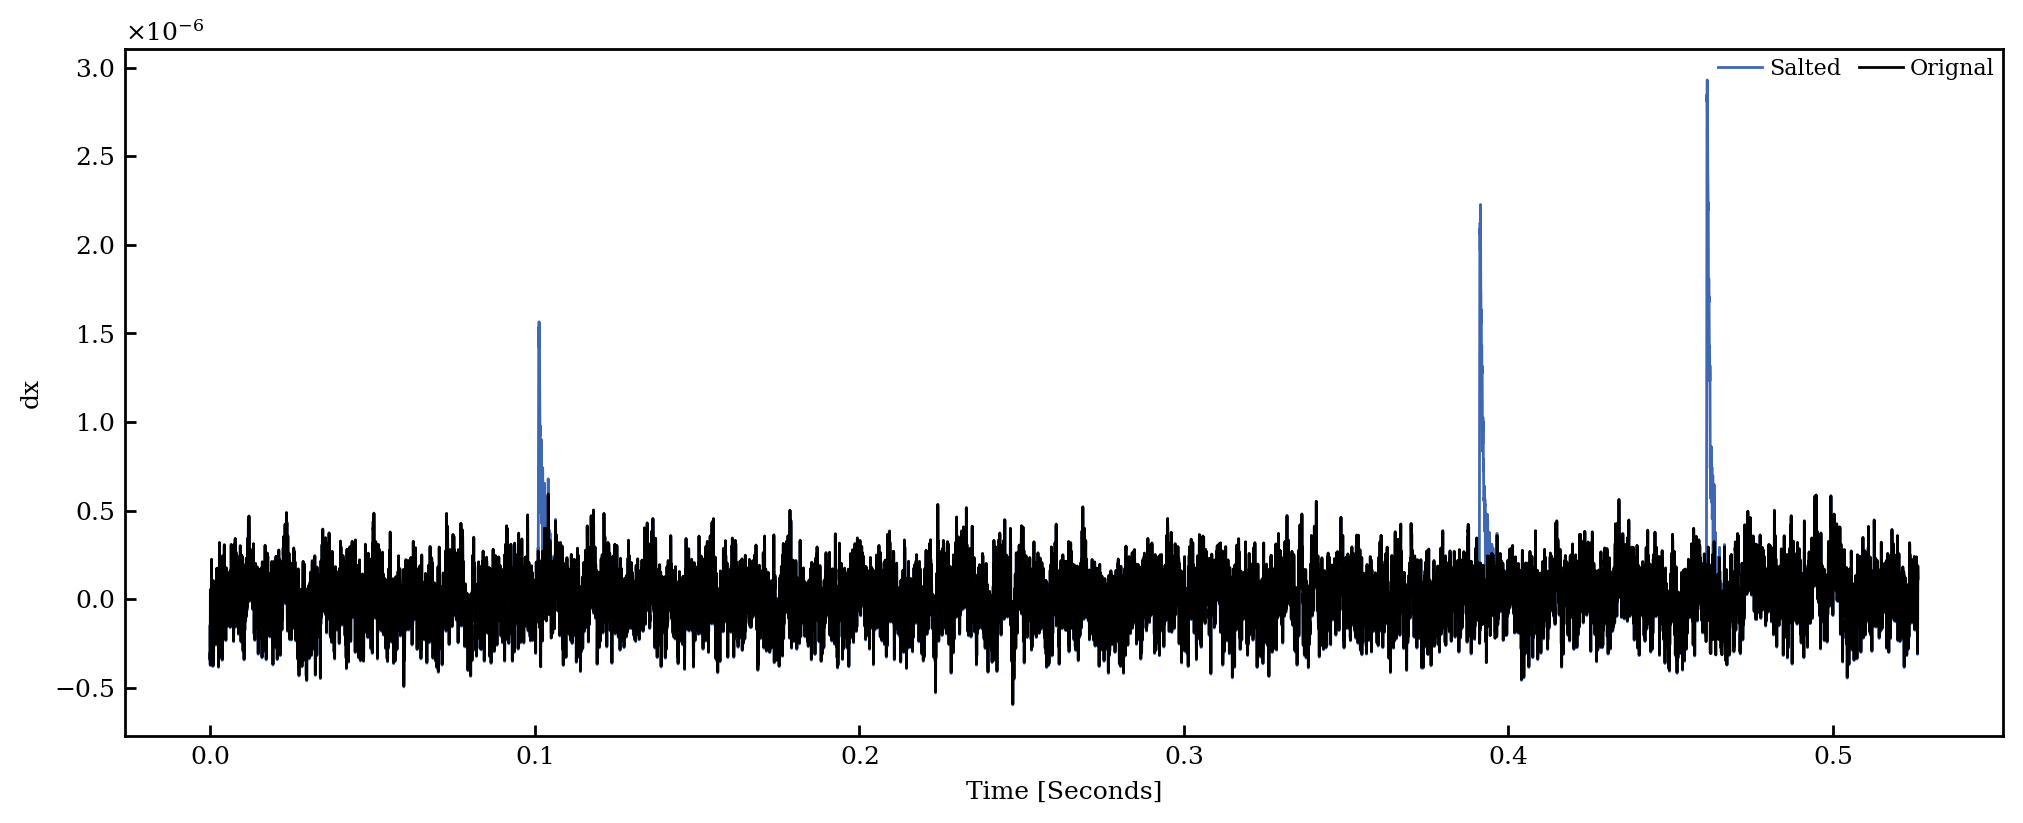

In [37]:
%matplotlib inline
plt.figure(figsize=(10, 4))
plt.plot(
    np.arange(20000) * 1 / 38e3,
    records_salt[0]["data_dx"][:20000],
    label="Salted",
    color="xenon_blue",
)
plt.plot(
    np.arange(20000) * 1 / 38e3, records_data[0]["data_dx"][:20000], label="Orignal", color="black"
)
plt.xlabel("Time [Seconds]")
plt.ylabel("dx")
plt.legend(ncol=2, loc="best")
plt.show()

The hits are from simulation.

To compare the simulation instruction (`truth`) to the reconstruction results (`hits`), we have a data type called `match`.

In [38]:
match = st_salt.get_array(run, "match")

/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/strax/plugins/plugin.py:212: UserWarning: 
            Looks like you are mixing config paradigms,
            this is not recommended.
            
  warn(message, UserWarning)
/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  self.interpolated_freqs[ch] = self.f_interpolation_models[ch](0)
Loading match: |          | 0.00 % [00:00<?]/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:542: ComplexWarning: Casting complex values to real discards the imaginary part
  r["data_dtheta"] = dtheta
/Users/lanqingyuan/Documents/GitHub/straxion/straxion/plugins/records.py:545: ComplexWarning: Casting complex values to real discards the imaginary part
  r["data_dx"] = (
/opt/anaconda3/envs/straxion/lib/python3.11/site-packages/strax/plugins/plugin.py:212: UserWarning: 
            Looks like you are mixing config p

Source finished!


For each truth ("simulation instruction"), there are three outcomes (`destiny`):
- `"found"`: Found one and only one hit whose time window overlaps with the time window of `truth`.
- `"lost"`: Found no hit whose time window overlaps with the time window of `truth`.
- `"split"`: Found more than one hit whose time window overlaps with the time window of `truth`. In this case, the hit related information will be assigned by the hit whose climax is closest to the truth's, 

In [39]:
st.data_info("match")

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,endtime,int64,Exclusive end time since unix epoch [ns]
2,channel,int16,Channel number where event occurred
3,energy_true,float32,True energy of the photon in meV
4,dx_true,float32,True dx value in dx units
5,destiny,<U5,"Destiny of the truth event: found, lost, or split"
6,hit_index,int32,Index of matched hit in hits array (NOT_FOUND_INDEX if not found)
7,length,int32,Length of matched hit waveform in samples
8,amplitude,float32,Maximum amplitude of the matched hit
9,amplitude_moving_average,float32,Maximum amplitude of matched hit (moving average)


The difference between the truth and the reconstruction results are interpreted as the impact of the noise.

Text(0, 0.5, 'Found Amplitude [dx]')

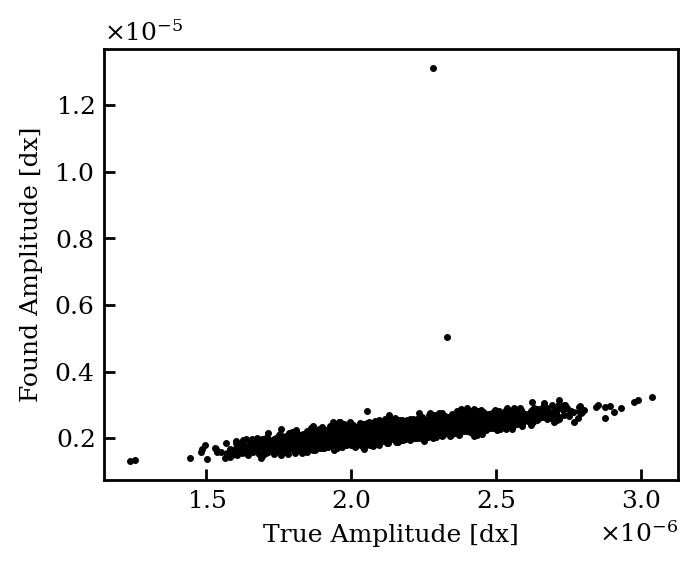

In [41]:
plt.scatter(
    match[match["destiny"] == "found"]["dx_true"], match[match["destiny"] == "found"]["amplitude"]
)
plt.xlabel("True Amplitude [dx]")
plt.ylabel("Found Amplitude [dx]")